In [1]:
from bertopic import BERTopic
from umap import UMAP
import pandas as pd
import matplotlib.pyplot as plt
# import nbformat
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
import json
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from nltk import download
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as func
import warnings

warnings.simplefilter(action='ignore')

SparkContext.setSystemProperty('spark.executor.memory', '16g')

sc = SparkContext("local", "App Name")

spark = SparkSession.builder.master("local").appName("App Name").getOrCreate()


C:\Users\aidan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def word_cloud(data, column, tfidf=False, bar=False):

    text = ' '.join(words for words in data[column])

    stop = stopwords.words('english')

    if tfidf == True:
        lemma = WordNetLemmatizer().lemmatize

        def tokenize(document):
            tokens = [lemma(w) for w in document.split()
                      if len(w) > 3 and w.isalpha() and w not in stop]
            return tokens

        vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(
            (2, 2)), strip_accents='unicode')

        tdm = vectorizer.fit_transform(data[column])

        tfidf_weights = [(word, tdm.getcol(idx).sum())
                         for word, idx in vectorizer.vocabulary_.items()]

        if bar == True:
            df = pd.DataFrame(dict(tfidf_weights).items(),
                              columns=['Key', 'Value'])
            df = df.nlargest(10, 'Value')
            plt.figure(figsize=(20, 15))
            plt.bar(x=df["Key"], height=df["Value"])
            plt.show()

        else:
            w = WordCloud(width=1920, height=1080, mode='RGBA',
                          background_color='white', max_words=2000
                          ).fit_words(dict(tfidf_weights))

            plt.figure(figsize=(20, 15))
            plt.imshow(w)
            plt.axis('off')
            plt.show()

    else:
        words = text.lower().split()
        words = [re.sub("[.,!?:;-='...'@#_]", " ", s) for s in words]
        words = [re.sub(r'\d+', '', w) for w in words]
        words = [word.strip() for word in words if word not in stop]
        # words.remove('')

        lemmatiser = WordNetLemmatizer()
        lem_words = [lemmatiser.lemmatize(w, pos='v') for w in words]
        words_counter = Counter(lem_words)

        if bar == True:
            df = pd.DataFrame(words_counter.items(),
                              columns=['Key', 'Value'])
            df = df.nlargest(10, 'Value')
            plt.figure(figsize=(20, 15))
            plt.bar(x=df["Key"], height=df["Value"])
            plt.show()

        else:
            w = WordCloud(width=1920, height=1080,
                          background_color='white'
                          ).generate_from_frequencies(words_counter)
            plt.figure(figsize=(20, 15))
            plt.imshow(w)
            plt.axis("off")
            plt.show()

# Load and Filter for Fishers

In [3]:
def yelp_json_to_df(df_name):
    df = spark.read.json(f'Yelp_Data/yelp_academic_dataset_{df_name}.json')
    feature_cols = list(filter(lambda x: "_id" not in x, df.columns))
    for x in feature_cols:
        df = df.withColumnRenamed(x, df_name + "_" + x)
    # df.printSchema()
    return df


yelp_business = yelp_json_to_df("business")

# Filtering for Food and Restraunts
yelp_business = yelp_business.withColumn(
    "business_categories", func.lower(func.col("business_categories")))
yelp_business = yelp_business.filter(yelp_business.business_categories.like("%food%") |
                                     yelp_business.business_categories.like("%restaurant%") |
                                     yelp_business.business_categories.like("%bar,%"))


def prep(x):
    x = str(x)
    x = x.lower()
    x = re.sub(" ", "", x)
    x = re.sub(",", " ", x)
    x = re.sub("(restaurants) | (restaurant) | (food) | (bar) | (bars)", "", x)

    return x


prep_udf = func.udf(prep, func.StringType())

yelp_business = yelp_business.withColumn(
    "business_categories", prep_udf(func.col("business_categories")))
yelp_business = yelp_business.filter(yelp_business.business_city == "Fishers")

reviews = yelp_json_to_df("review")

yelp_business_L1 = yelp_business.withColumnRenamed(
    "business_id", "business_id_2").select("business_id_2")

yelp_review_L1_cluster = reviews.join(
    yelp_business_L1, reviews.business_id == yelp_business_L1.business_id_2, "left")

yelp_business_L1 = yelp_business_L1.withColumnRenamed(
    "business_id_2", "business_id")

yelp_review_L1_cluster = yelp_review_L1_cluster.filter(
    yelp_review_L1_cluster.business_id_2.isNotNull())
yelp_review_L1_cluster = yelp_review_L1_cluster.drop("business_id_2")

df = yelp_review_L1_cluster.toPandas()

df.head(1)


,business_id,review_cool,review_date,review_funny,review_id,review_stars,review_text,review_useful,user_id
0,UEgiQRvpAeaq-QyEvm7Ysw,0,2017-11-06 21:59:14,0,OlaSUt3bA66VcCbVHhR0oA,5.0,Best place for salads! I go there every time I...,0,CbJ3Z5iL58ufqDhYWJFDtA


Text(0.5, 1.0, 'Distribution of Review Stars')

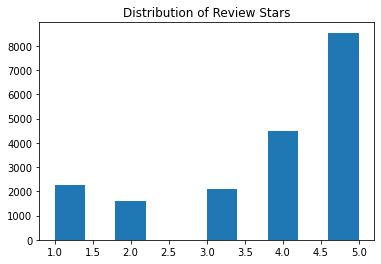

In [55]:
plt.hist(df.review_stars)
plt.title("Distribution of Review Stars")

# Text Preprocessing

In [4]:
def preprocess(df, column="text", spell_check=False):
    def remove_encoding_word(word):
        word = str(word)
        word = word.encode('ASCII', 'ignore').decode('ASCII')
        return word

    def remove_encoding_text(text):
        text = text.lower()
        text = str(text)
        text = ' '.join(remove_encoding_word(word)
                        for word in text.split() if word not in stop)
        return text

    speller = Speller(lang='en')

    def correct_review(review):
        corrected_review = " ".join([speller(word) for word in review.split()])
        return corrected_review

    stop = stopwords.words('english')

    # remove non alphabetical
    df[column] = df[column].map(
        lambda x: re.sub(r'[^a-zA-Z ^0-9]', '', str(x)))

    df = df.dropna(subset=[column])

    # remove random characters
    df[column] = df[column].apply(remove_encoding_text)

    if spell_check == True:

        # apply spell checker
        df[column] = df[column].apply(correct_review)

        return (df)

    else:
        return (df)


**Time intensive, about 70 minutes**

In [5]:
# preprocessed_reviews = preprocess(df, "review_text", spell_check=True)
# preprocessed_reviews.to_csv("preprocessed_reviews_fishers_spellchecked.csv", index=False)
preprocessed_reviews = pd.read_csv("preprocessed_reviews_fishers_spellchecked.csv")
preprocessed_reviews.head(1)

,business_id,review_cool,review_date,review_funny,review_id,review_stars,review_text,review_useful,user_id
0,UEgiQRvpAeaq-QyEvm7Ysw,0,2017-11-06 21:59:14,0,OlaSUt3bA66VcCbVHhR0oA,5.0,best place salads go every time im town lunch ...,0,CbJ3Z5iL58ufqDhYWJFDtA


# One Star Reviews

word cloud

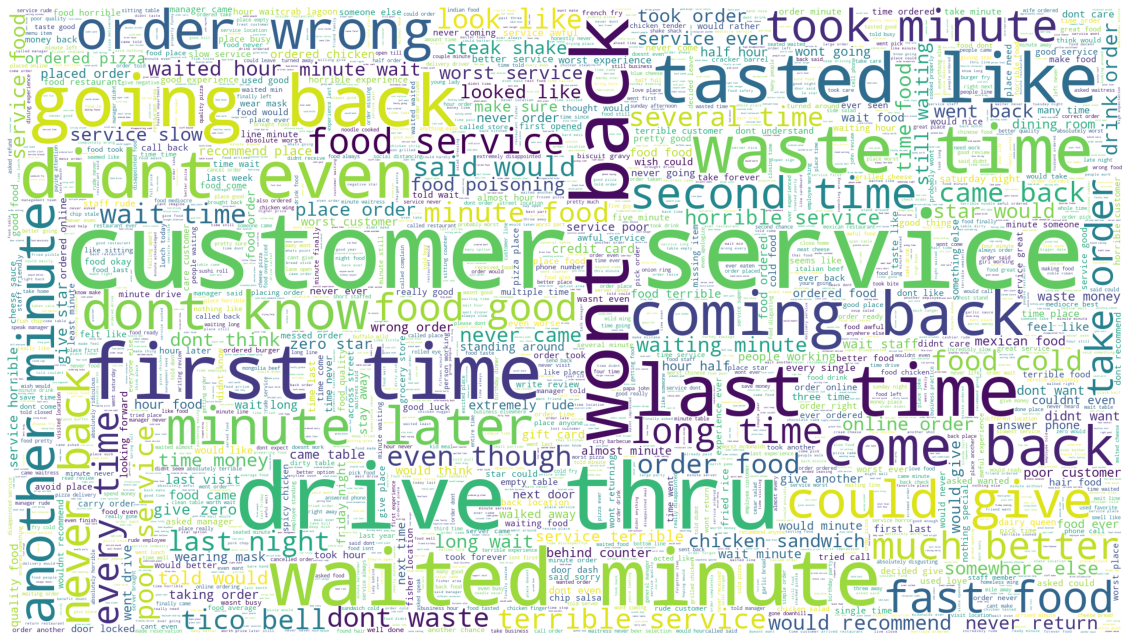

In [138]:
df1 = preprocessed_reviews[preprocessed_reviews['review_stars'] == 1.0]

word_cloud(df1, "review_text", bar=False, tfidf=True)

BERT Topic Model 

In [14]:
df1.head(1)

,business_id,review_cool,review_date,review_funny,review_id,review_stars,review_text,review_useful,user_id
11,F-vfI049swuwDR7HMOW1Fg,0,2013-10-24 15:44:04,0,F2wy1_4aaI637OoBikkcSA,1.0,first time last time worst margaritas were any...,0,bDZxpUlQrexV4bgyNH_L7A


In [72]:
umap_model1 = UMAP(random_state=42)

topic_model1 = BERTopic(umap_model=umap_model1, language="english", calculate_probabilities=True, verbose=True, min_topic_size=4)

topics1, probs1 = topic_model1.fit_transform(list(df1.review_text))

# topic_model1.visualize_topics()

Batches: 100%|██████████| 71/71 [01:07<00:00,  1.06it/s]
2023-02-23 17:38:38,002 - BERTopic - Transformed documents to Embeddings
2023-02-23 17:38:43,881 - BERTopic - Reduced dimensionality
2023-02-23 17:38:44,018 - BERTopic - Clustered reduced embeddings


In [73]:
# topic_model1.visualize_topics()
topic_model1.topic_sizes_

{0: 2233, 1: 28}

In [74]:
topic_model1.topic_labels_

{0: '0_food_order_service_time', 1: '1_mask_masks_wearing_wear'}

In [43]:
df1['topic'] = topics1
df1['review popularity'] = df1['review_useful'] + df1['review_funny'] + df1['review_cool']
df1.groupby('topic')['review popularity'].mean().sort_values(ascending=False)

topic
0    1.035826
1    0.892857
Name: review popularity, dtype: float64

In [29]:
topic_model1.get_representative_docs(1)

['two employees preparing food wore masks noses exposed told one felt uncomfortable way wearing mask walked away wont back',
 'food great honestly one unsafe restaurants right considering covid management aware wont anything 1 thing social distancing 6 ft apart enclosed environment literally 6 inches away ppl behind us 2 ft ppl next us 2 management wont enforce anyone wear mask multiple ppl walked table without wearing mask also coaching asked manager please enforce rules shocking said said wouldnt let 3 ppl walk without masks 3 cooks kitchen wear faces mask convenient expect see masks covering cooks noses food highly exposed aerosolized nose droplets4 clear signage wear face make inside coming covid symptoms also taking temperatures dont overall really pathetic keep patrons safe enforce rules set',
 'tonight first time dining for last manager named eric disregard social distancing personal space seated patio came table wearing face mask squared one foot face started talk surprised som

# Five Star Reviews

word cloud

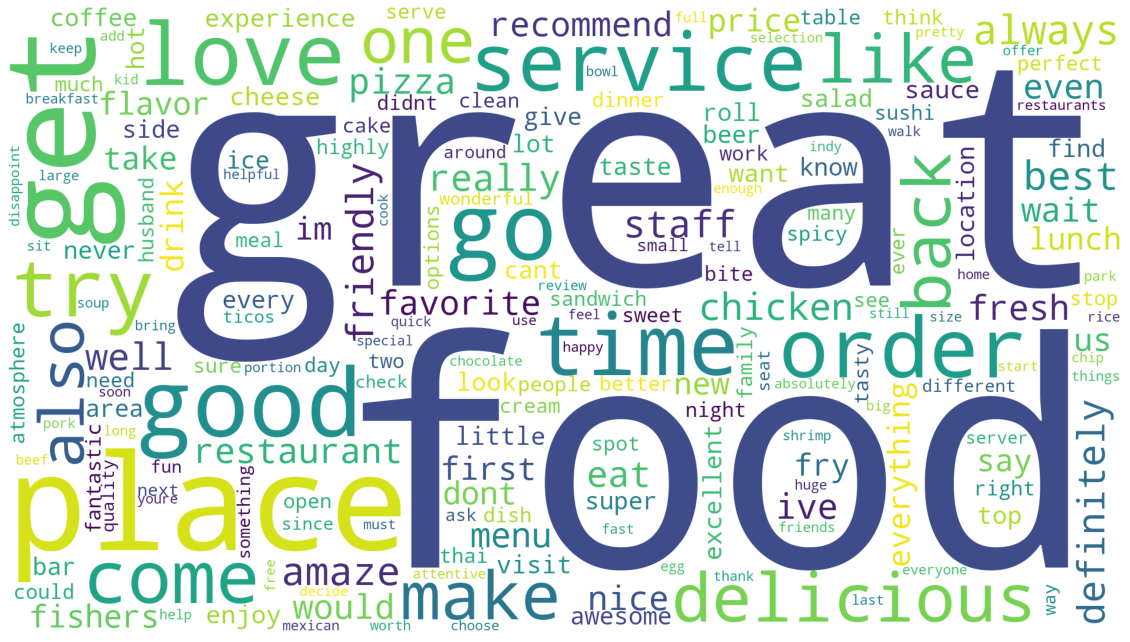

In [57]:
df5 = preprocessed_reviews[preprocessed_reviews['review_stars'] == 5.0]

word_cloud(df5, "review_text", bar=False)

BERT Topic Model

In [38]:
umap_model5 = UMAP(random_state=42)

topic_model5 = BERTopic(umap_model=umap_model5, language="english", calculate_probabilities=True, top_n_words=10, min_topic_size=20)

topics5, probs5 = topic_model5.fit_transform(list(df5.review_text))

topic_model5.visualize_topics()

2023-02-23 16:46:42,010 - BERTopic - Transformed documents to Embeddings
2023-02-23 16:46:53,858 - BERTopic - Reduced dimensionality
2023-02-23 16:46:54,307 - BERTopic - Clustered reduced embeddings


In [134]:
topic_model5.topic_labels_

{0: '0_great_food_place_good',
 1: '1_mexican_ticos_food_salsa',
 2: '2_golf_fun_topgolf_time',
 3: '3_flats_iguana_hot_sauce'}

In [135]:
topic_model5.topic_sizes_

{0: 7748, 1: 641, 2: 135, 3: 22}

In [136]:
df5['topic'] = topics5
df5['review popularity'] = df5['review_useful'] + df5['review_funny'] + df5['review_cool']
# df5.groupby('topic')['review popularity'].mean().sort_values(ascending=False).head(20)
df5.groupby('topic')['review popularity'].mean()

topic
0    1.275426
1    1.129485
2    1.503704
3    1.500000
Name: review popularity, dtype: float64

In [133]:
topic_model5.visualize_distribution(topic_model5.probabilities_[-1])

In [49]:
topic_model5.get_representative_docs(3)

['iguana flats one favorites living orlando area awhile husband used frequent lot dont get iguana flats much since moved back indiana always treat ive never bad meal love hot sauce bar options pick typically get bracketed chicken anchor delicious thats say dont great variety dummy things pick matter ive picked ive disappointed service place always quick friendly well always plus',
 'first discovered iguana flats lived orlando fl worried moved back indy area wouldnt get enjoy unique hot sauce bar unless went vacation however case discovered flats location fishersevery item menu delicious never disappointed eaten fan hot sauces sure check hot sauce bar levels heat sauce even youre like fan hot sauces still check smack sweet call sally sauce super good ticos dip chips itis saved room dessert enjoy chocolate chip cookies get chocolate chip cookie flats world you enough share others stop reading review go already',
 'iguana flats amazing loooooove bracketed chicken black bean flats everythi

# Taco Bell Reviews

Load in reviews of only Taco Bell 

In [117]:
def yelp_json_to_df(df_name):
    df = spark.read.json(f'Yelp_Data/yelp_academic_dataset_{df_name}.json')
    feature_cols = list(filter(lambda x: "_id" not in x, df.columns))
    for x in feature_cols:
        df = df.withColumnRenamed(x, df_name + "_" + x)
    # df.printSchema()
    return df


yelp_business_tacos = yelp_json_to_df("business")

# Filtering for Food and Restraunts
yelp_business_tacos = yelp_business_tacos.withColumn(
    "business_categories", func.lower(func.col("business_categories")))
yelp_business_tacos = yelp_business_tacos.filter(yelp_business_tacos.business_categories.like("%food%") |
                                     yelp_business_tacos.business_categories.like("%restaurant%") |
                                     yelp_business_tacos.business_categories.like("%bar,%"))


def prep(x):
    x = str(x)
    x = x.lower()
    x = re.sub(" ", "", x)
    x = re.sub(",", " ", x)
    x = re.sub("(restaurants) | (restaurant) | (food) | (bar) | (bars)", "", x)

    return x


prep_udf = func.udf(prep, func.StringType())

yelp_business_tacos = yelp_business_tacos.withColumn(
    "business_categories", prep_udf(func.col("business_categories")))
    
yelp_business_tacos = yelp_business_tacos.filter(yelp_business_tacos.business_name == "Taco Bell")

reviews = yelp_json_to_df("review")

yelp_business_tacos = yelp_business_tacos.withColumnRenamed(
    "business_id", "business_id_2").select("business_id_2")

yelp_review_tacos_cluster = reviews.join(
    yelp_business_tacos, reviews.business_id == yelp_business_tacos.business_id_2, "left")

yelp_business_tacos = yelp_business_tacos.withColumnRenamed(
    "business_id_2", "business_id")

yelp_review_tacos_cluster = yelp_review_tacos_cluster.filter(
    yelp_review_tacos_cluster.business_id_2.isNotNull())
yelp_review_tacos_cluster = yelp_review_tacos_cluster.drop("business_id_2")

df_tacos = yelp_review_tacos_cluster.toPandas()

df_tacos.head(1)


,business_id,review_cool,review_date,review_funny,review_id,review_stars,review_text,review_useful,user_id
0,tpSeNezanZDvsXWR7Hhi1w,0,2016-09-18 17:59:11,0,Ax8lbP7yYV_Ag2JwK-LorQ,1.0,"Literally, the worst Taco Bell I have ever bee...",2,EJqV61HlYmFEmzcIaRVVOw


In [118]:
df_tacos_preprocessed = preprocess(df_tacos, "review_text", spell_check=False)
# df_tacos_preprocessed_1 = preprocess(df_tacos, "review_text", spell_check=True)
# df_tacos_preprocessed_1.to_csv("df_tacos_preprocessed_spellchecked.csv")
# df_tacos_preprocessed_1 = pd.read_csv("df_tacos_preprocessed_spellchecked.csv")
df_tacos_preprocessed.head(1)

,business_id,review_cool,review_date,review_funny,review_id,review_stars,review_text,review_useful,user_id
0,tpSeNezanZDvsXWR7Hhi1w,0,2016-09-18 17:59:11,0,Ax8lbP7yYV_Ag2JwK-LorQ,1.0,literally worst taco bell ever restaurant filt...,2,EJqV61HlYmFEmzcIaRVVOw


Text(0.5, 1.0, 'Distribution of Taco Bell Reviews')

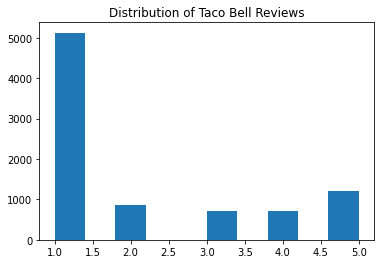

In [81]:
plt.hist(df_tacos_preprocessed.review_stars)
plt.title("Distribution of Taco Bell Reviews")

In [95]:
df_tacos_preprocessed.review_text.str.contains("taco bell").sum()

47

In [104]:
df_tacos_preprocessed_1 = pd.read_csv("df_tacos_preprocessed_spellchecked.csv")

df_tacos_1 = df_tacos_preprocessed_1[df_tacos_preprocessed_1['review_stars'] == 1.0]

df_tacos_1['review_text'] = df_tacos_1.review_text.str.replace("tico bell", " ")
df_tacos_1['review_text'] = df_tacos_1.review_text.str.replace("taco bell", " ")


umap_model_tacos = UMAP(random_state=42)

taco_model_1 = BERTopic(umap_model=umap_model_tacos, language="english", calculate_probabilities=True)
# , min_topic_size=5, top_n_words=5
topics_tacos_1, probs_tacos_1 = taco_model_1.fit_transform(list(df_tacos_1.review_text))


2023-02-23 22:40:29,086 - BERTopic - Transformed documents to Embeddings
2023-02-23 22:40:36,731 - BERTopic - Reduced dimensionality
2023-02-23 22:40:37,063 - BERTopic - Clustered reduced embeddings


In [109]:
# taco_model_1.visualize_topics()
# taco_model_1.get_representative_docs(0)
taco_model_1.topic_labels_

{-1: '-1_food_time_get_hair',
 0: '0_order_food_get_time',
 1: '1_closed_open_hours_close',
 2: '2_stars_give_could_would',
 3: '3_poisoning_food_stomach_ate',
 4: '4_breakfast_menu_morning_drive',
 5: '5_mask_wearing_masks_wear'}

In [88]:
taco_model_1.topic_sizes_

{0: 5103, 1: 23}

In [110]:
df_tacos_1['topic'] = topics_tacos_1
df_tacos_1['upvotes'] = df_tacos_1['review_useful'] + df_tacos_1['review_funny'] + df_tacos_1['review_cool']
df_tacos_1.groupby('topic')['upvotes'].mean()

topic
-1    0.942308
 0    0.898352
 1    0.553623
 2    0.788546
 3    1.083333
 4    0.833333
 5    0.347826
Name: upvotes, dtype: float64

In [168]:
taco_model_1.get_representative_docs(0)

['waited drive thru line hour 15 minutes take order first intercom screen black assumed would order window got window told needed get back line 8 cars already place order couldnt right absolutely ridiculous dont expect much fast food restaurant never one complain even order messed slightly used work industry absurd couldnt even take order waiting guess wont back',
 'far rudest restaurant experience ive ever life never write reviews definitely calls attention arrived drivethru line 12 waited line 40 minutes three cars got food three cars 40 minutes time finally got window said couldnt make food woman window said computer could see asked could online order pay instead using system said would work would ask people made food would leaving ask said leaving go home wont make food closed drive window left leaving us unattended without food keep mind arrived one hour closing time still 20 minutes make small order worked customer service past five years know entirely unacceptable never go   cha

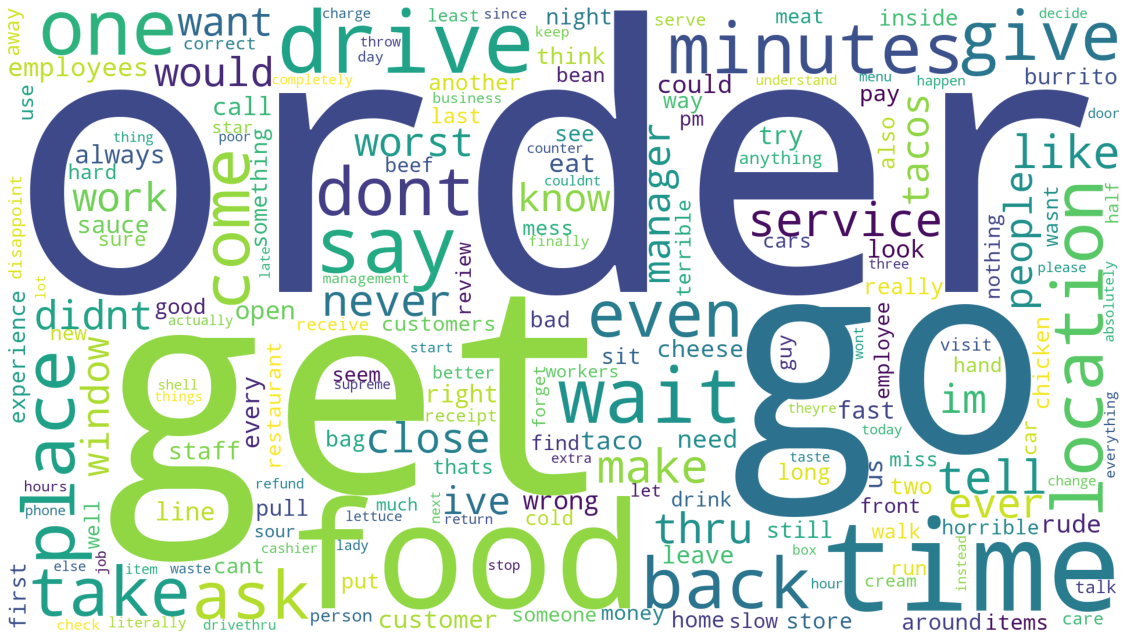

In [169]:
word_cloud(df_tacos_1[df_tacos_1['topic'] == 0], "review_text", bar=False)

In [128]:

df_tacos_5 = df_tacos_preprocessed[df_tacos_preprocessed['review_stars'] == 5.0]
# df_tacos_5 = df_tacos_preprocessed_1[df_tacos_preprocessed_1['review_stars'] == 5.0]

df_tacos_5['review_text'] = df_tacos_5.review_text.str.replace("tico bell", " ")
df_tacos_5['review_text'] = df_tacos_5.review_text.str.replace("taco bell", " ")
# df_tacos_5['review_text'] = df_tacos_5.review_text.str.replace("always", " ")
# df_tacos_5['review_text'] = df_tacos_5.review_text.str.replace("taco bell", " ")


umap_model_tacos5 = UMAP(random_state=42)

taco_model_5 = BERTopic(umap_model=umap_model_tacos5, language="english", calculate_probabilities=True)

topics_tacos_5, probs_tacos_5 = taco_model_5.fit_transform(list(df_tacos_5.review_text))


2023-02-23 22:54:32,386 - BERTopic - Transformed documents to Embeddings
2023-02-23 22:54:36,219 - BERTopic - Reduced dimensionality
2023-02-23 22:54:36,276 - BERTopic - Clustered reduced embeddings


In [129]:
taco_model_5.topic_labels_

{-1: '-1_order_always_food_drive',
 0: '0_food_service_always_order',
 1: '1_tb_one_drive_friendly'}

In [130]:
taco_model_5.topic_sizes_

{0: 1165, -1: 24, 1: 14}

In [131]:
# taco_model_5.topic_sizes_
df_tacos_5['topic'] = topics_tacos_5
df_tacos_5['upvotes'] = df_tacos_5['review_useful'] + df_tacos_5['review_funny'] + df_tacos_5['review_cool'] 
df_tacos_5.groupby('topic')['upvotes'].mean()

topic
-1    0.625000
 0    1.006867
 1    0.857143
Name: upvotes, dtype: float64

In [132]:
taco_model_5.get_representative_docs(0)

['awesome place may take little longer id like order employees care make sure nice hot really love   makes feel great get warm hello even go drive thru great job definitely feel like place gotten better sense remodel certainly better mcdonalds next takes 30 minutes anything   really good food always hot definitely place go great customer service friendly smiles conversations way go',
 'would give fast food joint five star review especially   older area st louis county well theres really one main reason rather combination things certainly share problems incorrect orders fast food places around st louis particularly   locations guess im surprised first usually hit place breakfast yes   breakfast way work almost never wait probably location somewhat beaten path however food always fresh surprising order something technically menu slight variant theres little change would sitting around premade could reasonably expect take bit longer make especially busy customers dont know often find fewe

# Aspect Analysis on Taco Reviews 

In [ ]:
nltk.download('vader_lexicon') # download the VADER lexicon for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [278]:
def get_sentiment_polarity_weighted(df, text):
    sid = SentimentIntensityAnalyzer() # initialize the VADER sentiment analyzer
    # function to extract the sentiment polarity score for each review
    def get_sentiment_polarity(review):
        sentiment_scores = sid.polarity_scores(review)
        return sentiment_scores['compound']

    # add a new column to the review dataframe with the sentiment polarity score for each review
    df['sentiment_score'] = df[text].apply(get_sentiment_polarity)

    # function to extract the aspect keywords from each review
    def get_aspect_keywords(review):
        tokens = nltk.word_tokenize(review.lower()) # convert text to lowercase and tokenize
        pos_tags = nltk.pos_tag(tokens) # part-of-speech tagging
        aspect_keywords = []
        for word, tag in pos_tags:
            if tag.startswith('NN'): # select only nouns and noun phrases
                aspect_keywords.append(word)
        return aspect_keywords

    df['aspect_keywords'] = df['review_text'].apply(get_aspect_keywords)
    df = df.explode('aspect_keywords')

    r = pd.DataFrame(df.groupby('aspect_keywords').mean())
    l = pd.DataFrame(df['aspect_keywords'].value_counts(normalize=False).sort_index())

    result = l.join(r)
    result.rename(columns={'aspect_keywords':'frequency'}, inplace=True)
    result['weighted_score'] = result['frequency'] * result['sentiment_score']


    return result


In [279]:
sentiment_results = get_sentiment_polarity_weighted(df_tacos_preprocessed_1, "review_text")
sentiment_results.sort_values('weighted_score', ascending=False)

,frequency,Unnamed: 0,review_cool,review_funny,review_stars,review_useful,sentiment_score,weighted_score
tico,6369,4314.431151,0.377139,0.548124,2.345894,0.848485,0.180590,1150.1776
food,6428,4276.581985,0.274269,0.397791,2.169726,0.706129,0.131103,842.7296
bell,4909,4283.728254,0.351803,0.538603,2.342432,0.806274,0.162075,795.6278
service,2536,4254.525631,0.257492,0.305205,2.358438,0.681388,0.135827,344.4577
staff,1213,4487.058533,0.220940,0.312448,2.667766,0.615829,0.268157,325.2745
...,...,...,...,...,...,...,...,...
money,487,4256.059548,0.182752,0.367556,1.221766,0.648871,-0.186489,-90.8199
rude,246,4361.821138,0.081301,0.166667,1.186992,0.455285,-0.397322,-97.7413
manager,1122,4412.176471,0.159537,0.266488,1.535651,0.655971,-0.087475,-98.1464
order,5411,4301.003881,0.233968,0.343375,1.782295,0.700795,-0.020367,-110.2082


In [277]:
sentiment_fishers = get_sentiment_polarity_weighted(preprocessed_reviews, "review_text")
sentiment_fishers.sort_values(by = 'weighted_score', ascending=False)

,frequency,review_cool,review_funny,review_stars,review_useful,sentiment_score,weighted_score
food,12353,0.374970,0.147737,3.653202,0.907796,0.734681,9075.5185
place,7992,0.496872,0.199825,3.894770,1.060561,0.792246,6331.6306
service,6308,0.346227,0.144895,3.649810,0.823557,0.695203,4385.3399
time,5877,0.425727,0.160116,3.567466,0.963076,0.717263,4215.3568
order,4672,0.422303,0.176584,3.102526,1.059075,0.585728,2736.5231
...,...,...,...,...,...,...,...
wrong,9,0.000000,0.000000,1.333333,0.777778,-0.415422,-3.7388
racist,7,0.000000,0.000000,1.000000,1.428571,-0.566657,-3.9666
prescription,7,0.000000,0.714286,1.571429,2.857143,-0.594943,-4.1646
behavior,8,0.125000,0.125000,1.625000,0.625000,-0.725375,-5.8030


In [281]:
sentiment_fishers.sort_values(by = 'weighted_score', ascending=False).head(25)

,frequency,review_cool,review_funny,review_stars,review_useful,sentiment_score,weighted_score
food,12353,0.374970,0.147737,3.653202,0.907796,0.734681,9075.5185
place,7992,0.496872,0.199825,3.894770,1.060561,0.792246,6331.6306
service,6308,0.346227,0.144895,3.649810,0.823557,0.695203,4385.3399
time,5877,0.425727,0.160116,3.567466,0.963076,0.717263,4215.3568
order,4672,0.422303,0.176584,3.102526,1.059075,0.585728,2736.5231
staff,3018,0.401922,0.117296,4.002982,0.862160,0.795890,2401.9959
restaurant,2595,0.453179,0.190366,3.743738,1.059345,0.776214,2014.2743
pizza,2695,0.467161,0.171429,3.687199,1.159926,0.747197,2013.6955
menu,2196,0.588342,0.183515,3.984062,1.222222,0.852487,1872.0611
fishers,2193,0.673051,0.165527,4.065207,1.352029,0.821667,1801.9160
